<a href="https://colab.research.google.com/github/jford59/RT1/blob/main/HW2/RT2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
Files already downloaded and verified
[1,   100] loss: 2.405
[1,   200] loss: 1.926
[1,   300] loss: 1.816
Epoch 1 completed, running validation...
Validation Loss: 1.6578, Accuracy: 38.11%
[2,   100] loss: 2.127
[2,   200] loss: 1.972
[2,   300] loss: 1.877
Epoch 2 completed, running validation...
Validation Loss: 1.6234, Accuracy: 39.57%
[3,   100] loss: 1.718
[3,   200] loss: 1.621
[3,   300] loss: 1.600
Epoch 3 completed, running validation...
Validation Loss: 1.5049, Accuracy: 44.87%
[4,   100] loss: 1.507
[4,   200] loss: 1.491
[4,   300] loss: 1.446
Epoch 4 completed, running validation...
Validation Loss: 1.2802, Accuracy: 53.74%
[5,   100] loss: 1.392
[5,   200] loss: 1.363
[5,   300] loss: 1.327
Epoch 5 completed, running validation...
Validation Loss: 1.1553, Accuracy: 58.56%
[6,   100] loss: 1.284
[6,   200] loss: 1.260
[6,   300] loss: 1.262
Epoch 6 completed, running validation...
Validation Loss: 1.3271, Accuracy: 53.69%
[7,   100] l

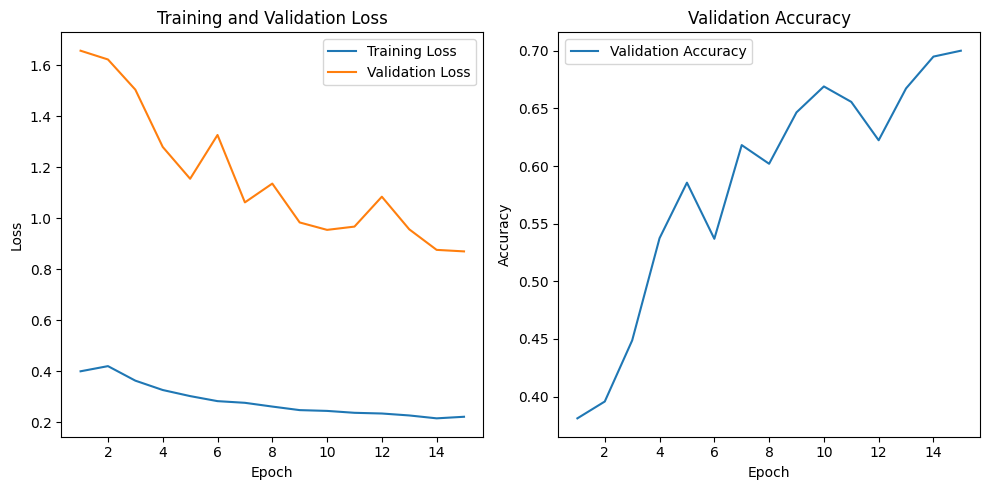

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define ResNet-18 model
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

# Function to train the model and collect metrics
def train_model(model, criterion, optimizer, scheduler, trainloader, testloader, device, num_epochs=10):
    train_losses = []
    val_losses = []
    val_accuracies = []

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

        # Collect training loss
        train_losses.append(running_loss / len(trainloader))

        # Print validation accuracy after each epoch
        print("Epoch {} completed, running validation...".format(epoch+1))
        val_loss, val_accuracy = validate_model(model, criterion, testloader, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Update learning rate
        scheduler.step()

    # Plot metrics
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to validate the model and collect validation loss and accuracy
def validate_model(model, criterion, testloader, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(testloader)
    val_accuracy = correct / total
    print('Validation Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, 100 * val_accuracy))
    return val_loss, val_accuracy

if __name__ == '__main__':
    torch.multiprocessing.freeze_support()

    # Set device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define transforms for the dataset
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    # Load CIFAR-10 dataset
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    # Instantiate the model
    model = ResNet18()

    # Set the model to the device
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)

    # Train the model and plot metrics
    train_model(model, criterion, optimizer, scheduler, trainloader, testloader, device, num_epochs=15)